# Objective

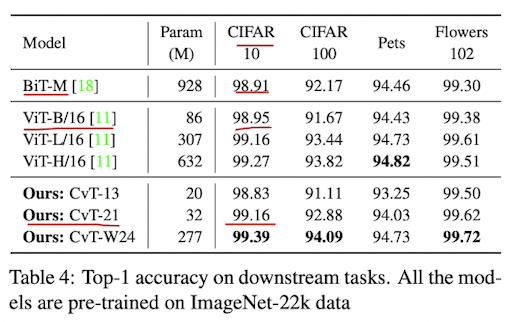

- Verify the performance of the CvT model by running the downstream task for CIFAR-10
- ViT Model is pre-trained on ImageNet-22k
- As a result of the experiment, CvT showed the best performance even though it took less training time.

## All of these codes are not in the paper. To verify the paper's experiment, I reproduced the codes by referring to the content learned in this course and the codes in the references.

## How to fine-tuning the model


Fine-tuning takes a long time. 

Thus, we repeated training: load model, train five epochs and save model

There are some {epoch.pth} files per model. 
- models (folder): BiT-M-{N}epoch.pth, ViT-L-{N}epoch.pth, CvT-21-{N}epoch.pth

As a result, we trained each model for 15 epochs.

## Setup Environment

In [ ]:
!nvidia-smi

Sun May 22 09:09:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import time
import re

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Data (CIFAR-10)

In [ ]:
batch_size = 8
num_classes = 10
num_epochs = 5

pre_epochs = 10 # epochs to start training

In [ ]:
train_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ])
train_set = torchvision.datasets.CIFAR10("./", train=True, 
                                         download=True, 
                                         transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

test_set = torchvision.datasets.CIFAR10("./", train=False, 
                                        download=True, 
                                        transform=test_transforms)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels)

torch.Size([8, 3, 224, 224])
tensor([2, 5, 1, 3, 9, 7, 6, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


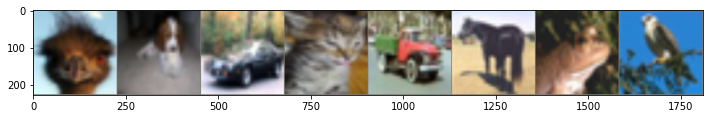

	bird 	dog 	car 	cat 	truck 	horse 	frog 	bird


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Inverse the normalisation
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img):
    img = inverse_normalize(tensor=img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(batch_size)))

## Load Model
 -  ImageNet-22k, 224x24, Pre-trained model ViT-B-16

In [ ]:
cd /content/gdrive/MyDrive/FinalProject/FineTuning/

/content/gdrive/MyDrive/FinalProject/FineTuning


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 15.8 MB/s 


In [ ]:
import timm
model = timm.create_model('vit_base_patch16_224_in21k',pretrained=True)

## Load the Previously Trained Model & Restruct the Last Layer
 - The last output must be 10

In [ ]:
# Last layer of model
model.head

Linear(in_features=768, out_features=21843, bias=True)

 - If Start Epoch is 0

In [ ]:
# If start epoch is 0
if pre_epochs == 0:
    # Replace the last layer
    # change out_features: 1000 to 10
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes, bias= True)
    model=model.to(device)

 - If Start Epoch is bigger than 0

In [ ]:
# If start epoch is not 0
if pre_epochs > 0:
    # load trained model before
    PATH = f'./models/ViT-B-{pre_epochs}epoch.pth'

    # replace the final output layer with new one (to apply the pre-trained model which is epoch > 0)
    # change out_features to 10
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes, bias= True)

    # apply the paramters to model
    model.load_state_dict(torch.load(PATH))
    model = model.to(device)

## Fine Tuning Strategy
 - In situations where there are many classes in downstream task, problems with low performance can occur

 - When the number of labels for the target task is large, perform backpropagation on every feature extractor will be better.

 - To obtaion the high accuracy, we finetuned on full layers
 - https://wandb.ai/suvadeep/pytorch/reports/Finetuning-of-ResNet-18-on-CIFAR-10-Dataset--VmlldzoxMDE2NjQ1
 - https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
 - https://androidkt.com/modify-pre-train-pytorch-model-for-finetuning-and-feature-extraction/

In [ ]:
params_to_update = []

# Check unfreezed layer
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print(name) # param to update. (it is same to whole parameters in model)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

cls_token
pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.3.norm1.weight
blocks.3.norm1.bias
blocks.3.attn.qkv.weight
blocks.3.attn.qkv.bias
blocks.3.attn.proj.wei

In [ ]:
# (number of images, number of output classes)
model(images.to(device)).shape

torch.Size([8, 10])

## Train (Fine Tuning)
 - ImageNet, 224x224, Pre-trained ViT-B-16 Fine-tuning on CIFAR-10

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

start = time.time()

# iterate 'pre_epoch' to 'pre_epoch + num_epohcs'
for epoch in range(pre_epochs, num_epochs + pre_epochs):
  print("\n")
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)                         
    loss = criterion(outputs, labels)               

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % ((n_total_steps//batch_size)//5) == 0:
      print(f'Epoch {epoch+1}/{num_epochs + pre_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

fine_tuning_time = time.time() - start

Total steps: 50000
Iterations per epoch: 6250


Epoch 11/15, Iteration 1250/6250, Loss=0.017207173630595207 
Epoch 11/15, Iteration 2500/6250, Loss=0.0005981180584058166 
Epoch 11/15, Iteration 3750/6250, Loss=0.0004118350625503808 
Epoch 11/15, Iteration 5000/6250, Loss=0.01823130063712597 
Epoch 11/15, Iteration 6250/6250, Loss=2.218725421698764e-05 


Epoch 12/15, Iteration 1250/6250, Loss=1.4915831343387254e-05 
Epoch 12/15, Iteration 2500/6250, Loss=2.1322784959920682e-05 
Epoch 12/15, Iteration 3750/6250, Loss=0.23400159180164337 
Epoch 12/15, Iteration 5000/6250, Loss=3.321322947158478e-05 
Epoch 12/15, Iteration 6250/6250, Loss=1.2084614354535006e-05 


Epoch 13/15, Iteration 1250/6250, Loss=0.01780296489596367 
Epoch 13/15, Iteration 2500/6250, Loss=0.00016389715892728418 
Epoch 13/15, Iteration 3750/6250, Loss=0.00016700699052307755 
Epoch 13/15, Iteration 5000/6250, Loss=8.925713700591587e-06 
Epoch 13/15, Iteration 6250/6250, Loss=0.0037037492729723454 


Epoch 14/15, Itera

## Test (Downstream task)

In [ ]:
# Formating Function
def nFormat(n):
    s = str(n)
    result = ""
    while True:
        if len(s) > 3:
            result = "," + s[-3:] + result
            s = s[:-3]
        else:
            result = s + result
            break
    return result

def tFormat(n):
    n = int(n)
    second = n%60
    minute = n//60
    return f'{minute}m {second}s'

In [ ]:
print('Final Epochs=',pre_epochs+num_epochs)

start = time.time()

# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

test_time = time.time() - start

Final Epochs= 15
Test Accuracy of the WHOLE CNN = 96.18 %
Accuracy of plane: 97.4 %
Accuracy of car: 98.1 %
Accuracy of bird: 96.0 %
Accuracy of cat: 89.9 %
Accuracy of deer: 99.1 %
Accuracy of dog: 90.5 %
Accuracy of frog: 98.6 %
Accuracy of horse: 96.4 %
Accuracy of ship: 98.3 %
Accuracy of truck: 97.5 %


In [ ]:
print('Number of Parameters: ',nFormat(sum(p.numel() for p in model.parameters())))
print('Fine-tuning Time per 5 epoch: ',tFormat(fine_tuning_time))
print('Test Time: ',tFormat(test_time))

Number of Parameters:  85,806,346
Fine-tuning Time per 5 epoch:  79m 44s
Test Time:  1m 8s


## Save Model

In [ ]:
PATH = f'./models/ViT-B-{pre_epochs + num_epochs}epoch.pth'
torch.save(model.state_dict(), PATH)

## Check the Load and Save Correctly
 - To verify the loading weights from .pth file correctly, reload the model and test it!
 - The test accuarcy must exactly same.

In [ ]:
import timm
model = timm.create_model('vit_base_patch16_224_in21k',pretrained=True)

# restruct the final output layer of init model
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes, bias= True)

# load the saved weights on the above
model.load_state_dict(torch.load(PATH))
model = model.to(device)

In [ ]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]

  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Test Accuracy of the WHOLE CNN = 96.18 %
Accuracy of plane: 97.4 %
Accuracy of car: 98.1 %
Accuracy of bird: 96.0 %
Accuracy of cat: 89.9 %
Accuracy of deer: 99.1 %
Accuracy of dog: 90.5 %
Accuracy of frog: 98.6 %
Accuracy of horse: 96.4 %
Accuracy of ship: 98.3 %
Accuracy of truck: 97.5 %


# Result
###CvT-21
 - Accuracy: 97.2%
 - Train Time: 94m 48s
 - Parameters: 31,241,546

###ViT-B-16
 - Accuracy: 96.18%
 - Train Time: 79m 44s
 - Parameters: 85,806,346

###BiT-M-R50x3
 - Accuracy: 96.26%
 - Train Time: 188m 20s
 - Parameters: 211,235,530

# References
 - https://github.com/rwightman/pytorch-image-models
 - https://huggingface.co/google/vit-base-patch16-224-in21k
 - https://arxiv.org/abs/2103.15808